### made w jpp

In [82]:
import torch
import torch.nn as nn
import snntorch as snn
import copy
import matplotlib.pyplot as plt
import networkx as nx

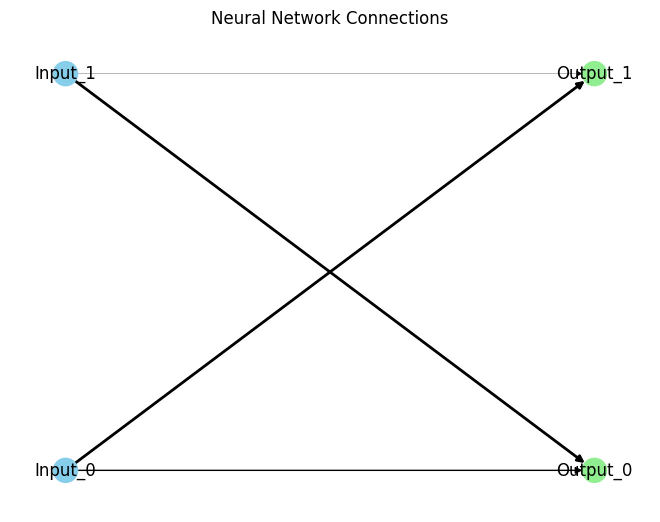

In [69]:
class FullyConnected2DLayer(nn.Module):
    def __init__(self, input_size, output_size, sparsity_index=None, weights=None):
        super(FullyConnected2DLayer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.input_size_flat = input_size[0] * input_size[1]
        self.output_size_flat = output_size[0] * output_size[1]
        self.output_size = output_size

        # Initialize weights
        if weights is not None:
            self.weights = nn.Parameter(weights)
        else:
            self.weights = nn.Parameter(torch.randn(self.output_size_flat, self.input_size_flat))
            if sparsity_index is not None:
                self.sparsify_myself(sparsity_index)

    def forward(self, input):
        # Assuming input is of shape (batch_size, input_size[0], input_size[1])
        batch_size = input.shape[0]
        flat_input = input.view(batch_size, self.input_size_flat)
        flat_output = torch.matmul(flat_input, self.weights.t())
        output = flat_output.view(batch_size, *self.output_size)
        return output

    def sparsify_myself(self, sparsity_index):
        with torch.no_grad():
            mask = torch.bernoulli(torch.full(self.weights.size(), sparsity_index))
            self.weights.data.mul_(mask)
            self.weights.data.add_((1 - mask) * 0.01)
            self.weights.data.div_(torch.sqrt(torch.tensor(sparsity_index)))

class SimpleSNN(nn.Module):
    def __init__(self, input_size, output_size, sparsity_index=None, threshold=1.0):
        super(SimpleSNN, self).__init__()
        self.fc = FullyConnected2DLayer(input_size, output_size, sparsity_index)
        self.lif = snn.Leaky(beta=0.5, threshold=threshold, reset_mechanism='zero')

    def forward(self, input_sequence, learn=False):
        mem = self.lif.init_leaky()
        spike_records = []
        closeness_scores = []

        for t in range(input_sequence.size(0)):
            input_t = input_sequence[t]
            x = self.fc(input_t)
            spk, mem = self.lif(x, mem)
            spike_records.append(spk)

            if learn:
                # Calculate closeness scores based on spiking activity and weights
                score = self.calculate_closeness_score(spk, t)
                closeness_scores.append(score)

        output_spikes = torch.stack(spike_records)

        if learn:
            return output_spikes, closeness_scores
        else:
            return output_spikes
    
    def calculate_closeness_score(self, spikes, timestep):
        # Implement the logic for calculating the closeness score
        # This is a placeholder function and needs to be implemented based on your specific needs
        pass

    def set_custom_weights(self, weight_matrix):
        """
        Set custom weights for the network, considering a 2D grid of neurons.

        :param weight_matrix: A list of tuples, each representing (input_x, input_y, output_x, output_y, weight),
                              where input_x, input_y, output_x, output_y are coordinates in the 2D grid.
        """
        # Initialize weights to zeros
        self.fc.weights = nn.Parameter(torch.tensor(custom_weights))

    def visualize_weights(self):
            """
            Visualize the weights of the network.
            """
            weight_matrix = self.fc.weights.data.numpy()
            plt.imshow(weight_matrix, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.title("Network Weights")
            plt.xlabel("Input Neurons")
            plt.ylabel("Output Neurons")
            plt.show()

    def visualize_network(self):
        """
        Visualize the network connections with edge thickness representing weight strength.
        """
        G = nx.DiGraph()
        weight_matrix = self.fc.weights.data.numpy()

        # Add nodes for input and output neurons
        input_neurons = [f"Input_{i}" for i in range(self.fc.input_size_flat)]
        output_neurons = [f"Output_{i}" for i in range(self.fc.output_size_flat)]
        G.add_nodes_from(input_neurons, layer="input")
        G.add_nodes_from(output_neurons, layer="output")

        # Add edges with weights
        for i, input_neuron in enumerate(input_neurons):
            for j, output_neuron in enumerate(output_neurons):
                weight = weight_matrix[j, i]
                if weight != 0:
                    G.add_edge(input_neuron, output_neuron, weight=abs(weight))  # Use absolute weight for edge thickness

        # Positioning the nodes for visualization
        pos = {}
        pos.update((node, (1, i)) for i, node in enumerate(input_neurons))  # Input layer
        pos.update((node, (2, i)) for i, node in enumerate(output_neurons))  # Output layer

        # Draw the graph
        edge_widths = [G[u][v]['weight'] * 2 for u, v in G.edges]  # Scale edge thickness by weight
        nx.draw(G, pos, with_labels=True, node_color=["skyblue" if node in input_neurons else "lightgreen" for node in G],
                width=edge_widths)
        plt.title("Neural Network Connections")
        plt.show()


# Example usage
input_size = (2,1)
output_size = (2,1)
model = SimpleSNN(input_size, output_size, sparsity_index=0.1, threshold=1.0)

# Custom weight matrix: [input index, output index, weight]
custom_weights = [[0.5,1.0],[1.0,0.1]]
model.set_custom_weights(custom_weights)

# Visualize the weights
model.visualize_network()

In [70]:
def create_input_sequence(signal_length, spike_frequency, input_size=(2, 1), flip_halfway=True):
    """
    Create an input sequence for neurons with the specified shape.

    :param signal_length: Total length of the signal.
    :param spike_frequency: Frequency of spikes (e.g., spike every 'n' timesteps).
    :param input_size: The shape of each input (number of neurons, dimension).
    :param flip_halfway: Whether to flip the firing pattern halfway through the signal.
    :return: A numpy array representing the input sequence of shape (signal_length, input_size[0], input_size[1]).
    """
    half_length = signal_length // 2

    neuron_0_pattern = torch.zeros(signal_length)
    neuron_1_pattern = torch.zeros(signal_length)

    neuron_0_pattern[half_length::spike_frequency] = 1
    neuron_1_pattern[:half_length:spike_frequency] = 1

    if flip_halfway:
        neuron_0_pattern, neuron_1_pattern = neuron_1_pattern, neuron_0_pattern

    # Combine and reshape the patterns into the desired 3D array
    input_sequence = torch.stack([neuron_0_pattern, neuron_1_pattern], axis=1)
    input_sequence = input_sequence.reshape(signal_length, 1, input_size[0], input_size[1])

    return input_sequence

# Example usage
signal_length = 100
spike_frequency = 5
input_size = (2, 1)  # 2 neurons, 1 dimension

input_sequence = create_input_sequence(signal_length, spike_frequency, input_size)
input_sequence.shape  # Should be (100, 2, 1)

torch.Size([100, 1, 2, 1])

In [72]:
model.forward(input_sequence, learn=True)

AttributeError: 'SimpleSNN' object has no attribute 'calculate_closeness_score'

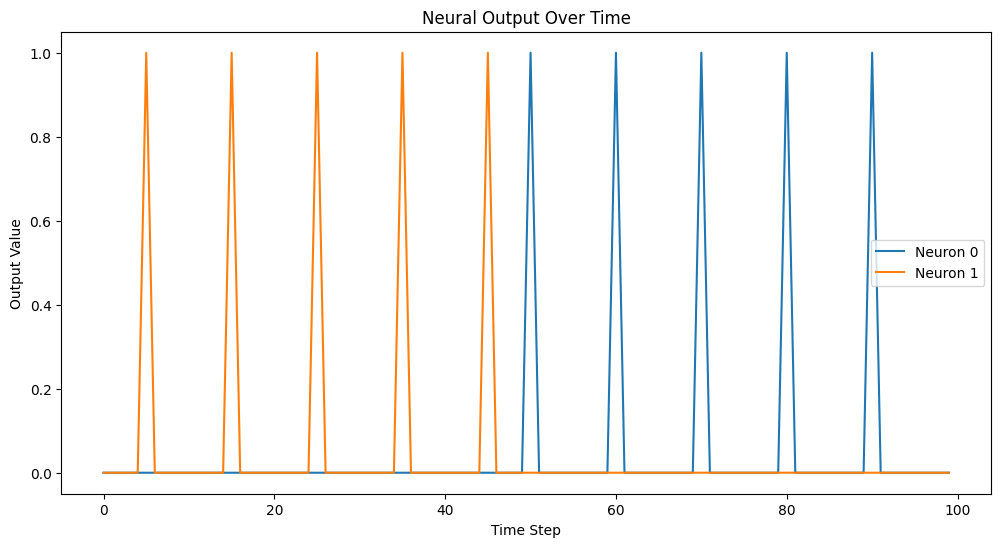

In [71]:
import matplotlib.pyplot as plt

def visualize_output(output_tensor):
    """
    Visualize the output of the model over time.

    :param output_tensor: A 4D tensor with shape [time_steps, batch_size, height, width].
    """
    # Reshape the output to 2D for easier handling (time_steps, neurons)
    output_reshaped = output_tensor.reshape(output_tensor.shape[0], -1)

    # Plotting
    plt.figure(figsize=(12, 6))
    for i in range(output_reshaped.shape[1]):
        plt.plot(output_reshaped[:, i], label=f'Neuron {i}')
    
    plt.xlabel('Time Step')
    plt.ylabel('Output Value')
    plt.title('Neural Output Over Time')
    plt.legend()
    plt.show()

# Example usage
# Assuming `model_output` is the output from your model with shape [100, 1, 2, 1]
# model_output = model(input_sequence)
# visualize_output(model_output)
visualize_output(model(input_sequence).detach())

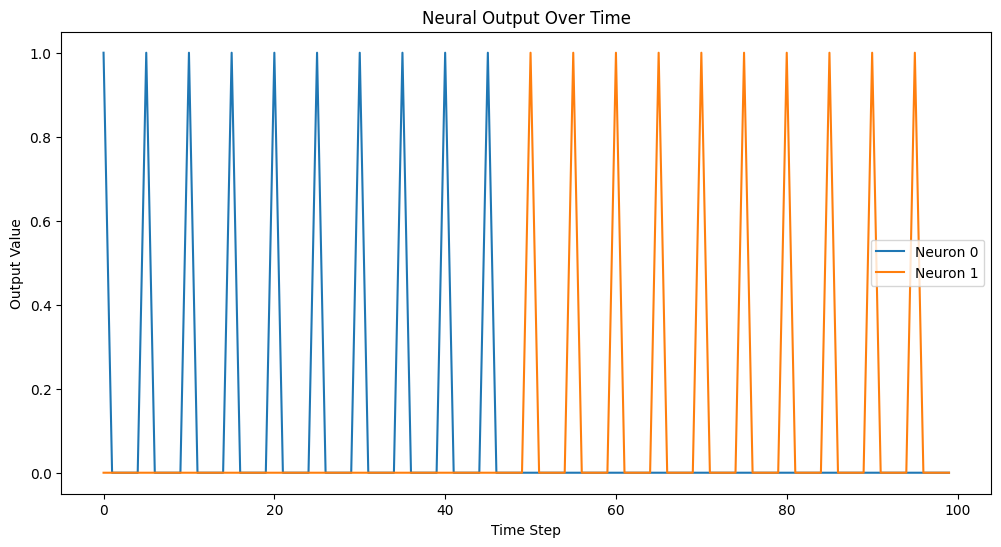

In [68]:
visualize_output(input_sequence)

In [45]:
model.fc.weights

Parameter containing:
tensor([[0.5000, 1.0000],
        [1.0000, 0.5000]], requires_grad=True)

In [73]:
class SpikeRecord:
    def __init__(self):
        self.data = []

    def add_spike_data(self, spike_data):
        self.data.append(spike_data.detach())

    def get_size(self):
        if self.data:
            return torch.stack(self.data).size()
        else:
            return (0,)

    def visualize(self):
        spike_tensor = torch.stack(self.data)
        ani = tonic.utils.plot_animation(spike_tensor[:,0])
        return HTML(ani.to_jshtml())

    def clear_data(self):
        self.data = []
        
    def data(self):
        return torch.stack(self.data)

In [78]:
class FullyConnected2DLayer(nn.Module):
    def __init__(self, input_size, output_size, sparsity_index):
        super(FullyConnected2DLayer, self).__init__()
        self.input_size = input_size[0] * input_size[1]
        self.output_size_flat = output_size[0] * output_size[1]  # Flattened size
        self.output_size = output_size  # 2D output size
        self.weights = nn.Parameter(torch.randn(self.output_size_flat, self.input_size))
        self.sparsify_myself(sparsity_index)

    def forward(self, input):
        # Assuming input is of shape (batch_size, height, width)
        batch_size, height, width = input.shape
        flat_input = input.view(batch_size, self.input_size)
        flat_output = torch.matmul(flat_input, self.weights.t())
        output = flat_output.view(batch_size, *self.output_size)  # Use the 2D output size
        return output

    def sparsify_myself(self, sparsity_index):
        with torch.no_grad():
            mask = torch.bernoulli(torch.full(self.weights.size(), sparsity_index))
            self.weights.data.mul_(mask)
            # Rescale the weights to keep the variance stable, sqrt() expects a scalar if sparsity_index is a scalar
            self.weights.data.div_(torch.sqrt(torch.tensor(sparsity_index)))
            
class SpatialSNN(nn.Module):
    def __init__(self, sparsity_index, threshold):
        super(SpatialSNN, self).__init__()
        self.input_output_size = (64,64)

        # Initialize separate pathways with sparsity
        self.fc2d_on = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)
        self.fc2d_off = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)

        # Combined fully connected layer after ON and OFF pathways
        self.fc2d_1 = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)

        # Final fully connected layer
        self.fc2d_2 = FullyConnected2DLayer(self.input_output_size, self.input_output_size, sparsity_index)

        # Initialize lists to record spikes
        self.spike_records_on = SpikeRecord()
        self.spike_records_off = SpikeRecord()
        self.spike_records_layer1 = SpikeRecord()
        self.spike_records_layer2 = SpikeRecord()
        
        self.init_leaky(threshold)
    
    def init_leaky(self, threshold):
        
        self.lif1 = snn.Leaky(beta=0.5, threshold=threshold, reset_mechanism='zero')
        self.lif2 = snn.Leaky(beta=0.5, threshold=threshold, reset_mechanism='zero')
        # Leaky integrate-and-fire neurons for ON and OFF pathways
        self.lif_on = snn.Leaky(beta=0.5, threshold=threshold, reset_mechanism='zero')
        self.lif_off = snn.Leaky(beta=0.5, threshold=threshold, reset_mechanism='zero')
        
    def forward(self, input_sequence_on, input_sequence_off):
        
        self.mem_on = self.lif_on.init_leaky()
        self.mem_off = self.lif_off.init_leaky()
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()

        for t in range(input_sequence_on.size(0)):
            # Get input for the current time step for ON and OFF events
            input_t_on = input_sequence_on[t]
            input_t_off = input_sequence_off[t]

            # ON pathway with size (BATCH_SIZE, 28,28)
            x_on = self.fc2d_on(input_t_on)
            spk_on, self.mem_on = self.lif_on(x_on, self.mem_on)

            # OFF pathway
            x_off = self.fc2d_off(input_t_off)
            spk_off, self.mem_off = self.lif_off(x_off, self.mem_off)
            # Combine the ON and OFF spikes
            combined_spk = torch.add(spk_on, spk_off)
            # First combined layer
            x = self.fc2d_1(combined_spk)
            spk1, self.mem1 = self.lif1(x, self.mem1)

            # Second layer
            x = self.fc2d_2(spk1)
            spk2, self.mem2 = self.lif2(x, self.mem2)
            self.spike_records_on.add_spike_data(spk_on)
            self.spike_records_off.add_spike_data(spk_off)
            self.spike_records_layer1.add_spike_data(spk1)
            self.spike_records_layer2.add_spike_data(spk2)
        
        
        # Stack the recorded spikes

        return self.spike_records_on.data, self.spike_records_off.data, self.spike_records_layer1.data, self.spike_records_layer2.data
    
sparsity_index = 0.0001  # that's a lot of sparse
threshold_model = SpatialSNN(sparsity_index, threshold=18.0)
allpass_model = copy.deepcopy(threshold_model)
allpass_model.init_leaky(threshold=0.01)

In [79]:
threshold_model.fc2d_1.weights.shape

torch.Size([4096, 4096])

torch.Size([199, 8, 2, 64, 64])


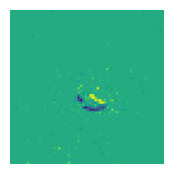

In [84]:
import random
from torch.utils.data import DataLoader, Subset
import tonic
import tonic.transforms as transforms
from tonic import datasets
from tonic import DiskCachedDataset
from IPython.display import HTML

# Load the dataset
dataset = datasets.DVSGesture(save_to='./data', train=True)
sensor_size = datasets.DVSGesture.sensor_size

# Define frame transformation
frame_transform = transforms.Compose([
    transforms.CropTime(max=2_000_000),
    transforms.Downsample(spatial_factor=0.25),  # Make sure this downsamples to (32, 32)
    transforms.ToFrame(sensor_size=(32, 32), time_window=10_000)
])

# Load the train and test datasets with the specified transformations
trainset = datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

# Subsampling parameters
batch_size = 8
subsample_percent = 10

# Subsample datasets
train_subsample_idx = random.sample(range(len(trainset)), int(len(trainset) * subsample_percent // 100))
test_subsample_idx = random.sample(range(len(testset)), int(len(testset) * subsample_percent // 100))
trainset = Subset(trainset, train_subsample_idx)
testset = Subset(testset, test_subsample_idx)

# Cache datasets
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

# DataLoader
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))

# Retrieve a batch of frames and move time to the first dimension
frames, targets = next(iter(train_loader))
frames = frames.movedim(0, 1)

# Check the shape of the frames to ensure they are correct
print(frames.shape)
ani = tonic.utils.plot_animation(frames[:,0])
HTML(ani.to_jshtml())

In [81]:
on_A, off_A, layer1_A, layer2_A = threshold_model(frames[:,:,0], frames[:,:,1])
on_B, off_B, layer1_B, layer2_B = allpass_model(frames[:,:,0], frames[:,:,1])

In [ ]:
import matplotlib.pyplot as plt
#frames = torch.concat((torch.stack(layer1_A.data),torch.stack(layer1_B.data)), -1)
frames = torch.stack(layer1_A.data)-torch.stack(layer1_B.data)
expanded_frames = torch.cat((frames.unsqueeze(2), torch.zeros_like(frames).unsqueeze(2)), dim=2)
expanded_frames.shape
ani = tonic.utils.plot_animation(expanded_frames[:,0])
HTML(ani.to_jshtml())

In [116]:
print(torch.sum(torch.stack(layer2_A.data))/torch.sum(torch.stack(layer2_B.data)))

tensor(0.4458)


In [181]:
import torch

# Assume spike_tensor is your tensor with shape [time_steps, height, width]
spike_tensor = torch.stack(layer1_B.data)[:,0]  # Your [199, 64, 64] tensor here

def temporal_gravitational_score(spike_tensor):
    # Initialize the tensor that will hold the temporal gravitational scores
    temporal_scores = torch.zeros_like(spike_tensor).float()

    # Iterate over each spatial location
    for i in range(spike_tensor.shape[1]):
        for j in range(spike_tensor.shape[2]):
            # Get the time indices where spikes occur for this neuron
            spike_times = torch.nonzero(spike_tensor[:, i, j], as_tuple=True)[0]

            # Calculate the score for each spike based on previous spikes
            for time_index in range(1, len(spike_times)):
                current_time = spike_times[time_index]
                previous_times = spike_times[:time_index]
                time_diffs = current_time - previous_times
                # Avoid division by zero and calculate the score
                score = torch.sum(torch.exp(-1*time_diffs.float()))
                temporal_scores[current_time, i, j] = score

    return temporal_scores

In [182]:
# Assume high_threshold_spikes is your tensor for the high threshold model with shape [time_steps, height, width]
high_threshold_spikes =  torch.stack(layer1_A.data)[:,0] # Your [199, 64, 64] tensor here
low_threshold_scores = temporal_gravitational_score(spike_tensor)  # Calculated from the previous step

# Count the number of spikes in the high threshold model
num_high_threshold_spikes = high_threshold_spikes.sum()
print(num_high_threshold_spikes)
print(spike_tensor.sum())
# Flatten the scores and sort them to get the highest values
flat_scores = low_threshold_scores.flatten()
sorted_scores, indices = torch.sort(flat_scores, descending=True)

# Now select as many highest scores as there are spikes in the high-threshold model
# This gives us the indices in the flattened tensor that we should select
selected_indices = indices[:int(num_high_threshold_spikes)]

# Create a new tensor to store the selected spikes
selected_spikes = torch.zeros_like(flat_scores).bool()

# Set the selected indices to True
selected_spikes[selected_indices] = True

# Reshape the selected_spikes back to the original shape [time_steps, height, width]
selected_spikes = selected_spikes.view_as(high_threshold_spikes)
print(selected_spikes.sum())
# Now selected_spikes is a boolean tensor with the same number of spikes as in the high_threshold_spikes tensor,
# containing the spikes with the highest temporal gravitational scores


tensor(1007.)
tensor(1314.)
tensor(1007)


In [187]:
frames = selected_spikes.int()-high_threshold_spikes.int()
(frames>0).sum()

tensor(255)

torch.Size([199, 64, 128])
torch.Size([199, 2, 64, 128])


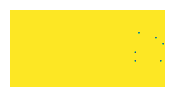

In [190]:
frames = torch.concat((selected_spikes.int(),high_threshold_spikes.int()), -1)
#frames = selected_spikes.int() - high_threshold_spikes.int()
print(frames.shape)
expanded_frames = torch.cat((frames.unsqueeze(1), torch.zeros_like(frames).unsqueeze(1)), dim=1)
print(expanded_frames.shape)
ani = tonic.utils.plot_animation(expanded_frames)
HTML(ani.to_jshtml())

In [118]:
#TL;DR this box loads the dataset events
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
events, _ = dataset[8]
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.125),
                                      transforms.ToFrame(sensor_size=(32,32),
                                                         time_window=10_000) ])

trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

batch_size = 8

subsample_percent = 10

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset = Subset(testset,  test_subsample_idx)
##########################################

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))
frames, targets = next(iter(train_loader))
frames = frames.movedim(0,1)

ModuleNotFoundError: No module named 'tonic.dataset_utils'

In [117]:
frames.shape

torch.Size([199, 8, 2, 64, 64])

In [ ]:

input_sequence = torch.randn(50, 8, 2, 28, 28)
out = model(input_sequence[:,:,0], input_sequence[:,:,1])

In [ ]:

class SpatialSNN(nn.Module):
    def __init__(self):
        super(SpatialSNN, self).__init__()
        # Define the size of the input and output for the layers
        self.input_output_size = (28, 28)
        
        # Two separate fully connected 2D layers
        self.fc2d_1 = FullyConnected2DLayer(self.input_output_size, self.input_output_size)
        self.lif1 = snn.Leaky()
        self.fc2d_2 = FullyConnected2DLayer(self.input_output_size, self.input_output_size)
        self.lif2 = snn.Leaky()

        # Initialize lists to record spikes - will be overwritten each forward pass
        self.spike_records_layer1 = []
        self.spike_records_layer2 = []

    def forward(self, input_sequence):
        mem1 = mem2 = None

        # Process each time step
        for t in range(input_sequence.size(0)):
            # Get input for the current time step
            input_t = input_sequence[t]

            # First layer
            x = self.fc2d_1(input_t)
            spk1, mem1 = self.lif1(x, mem1)
            self.spike_records_layer1.append(spk1.detach())

            # Second layer
            x = self.fc2d_2(spk1)
            spk2, mem2 = self.lif2(x, mem2)
            self.spike_records_layer2.append(spk2.detach())

        # Stack the recorded spikes
        self.spike_records_layer1 = torch.stack(self.spike_records_layer1, dim=0)
        self.spike_records_layer2 = torch.stack(self.spike_records_layer2, dim=0)

        # Return the final spikes and membrane potentials
        return self.spike_records_layer1, mem1, self.spike_records_layer2, mem2

In [ ]:
# Instantiate the network
model = SpatialSNN()

# Prepare input, assume spike_input is [time, batch, 28, 28]
spike_input = torch.rand(199, 1, 28, 28)  # Example input with time dimension

# Run the forward pass to process the entire sequence
spikes_layer1, mem1, spikes_layer2, mem2 = model(spike_input)

# Access the spike recordings
spike_records_layer1 = model.spike_records_layer1.cpu().numpy()
spike_records_layer2 = model.spike_records_layer2.cpu().numpy()

# The spike_records_layer1 and spike_records_layer2 have shape [time, batch, 28, 28]


In [ ]:
import torch

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sparsity_index):
        super(Net, self).__init__()
        
        self.ON_event_pathway = torch.nn.Sequential( snn.Leaky(beta=0.5, threshold=1),
                                                # Other layers specific to ON pathway
                                            )
        self.OFF_event_pathway = torch.nn.Sequential( snn.Leaky(beta=0.5, threshold=1),
                                                # Other layers specific to ON pathway
                                            )
        
        self.fc1 = torch.nn.Linear(hidden_size, output_size)
        self.ON_membrane_state = self.ON_event_pathway.init_leaky(batch_size=8)
        self.OFF_membrane_state = self.OFF_event_pathway.init_leaky(batch_size=8)
        
        self.spike_records = []
        # Uncomment to add layer
        # self.fc1 = torch.nn.Linear(hidden_size, hidden_size)
        # self.fc2 = torch.nn.Linear(hidden_size, output_size)
        # self.sparsify_layer(self.fc2, sparsity_index)
        
        # Custom weight initialization with sparsity
        self.sparsify_layer(self.ON_event_pathway, sparsity_index)
        self.sparsify_layer(self.OFF_event_pathway, sparsity_index)
        self.sparsify_layer(self.fc1, sparsity_index)
        
    def forward(self, on_spikes, off_spikes):
        for t in range(on_spikes.size(0)):
            # Get input for the current time step
            input_t = spike_input[t].unsqueeze(0)  # Add a batch dimension if necessary

            # Forward pass through the network
            spk_out, mem_states = model(input_t, mem_states)

            # Record the spikes; spk_out is a tensor with spikes (1's) at firing times
            spike_records.append(spk_out.detach().cpu().numpy())

    # Convert list of arrays into a numpy array for easier analysis
    spike_records = np.stack(spike_records, axis=0)

            # Forward pass through the network
            on_spikes = self.ON_event_pathway(on_spikes)
            off_spikes = self.OFF_event_pathway(off_spikes)

            #after passing ON and OFF spikes thru the first layer they are merged
            on_spikes = self.ON_event_pathway(on_spikes)
            off_spikes = self.OFF_event_pathway(off_spikes)
            out = self.fc1(on_spikes+off_spikes)
            # out = self.fc2(out) #If fc2 present
        return out
        
    def _sparsify_layer(self, unsparse_layer, sparsity_index):
        """Custom weight initializer for sparse connections."""
        with torch.no_grad():
            mask = torch.bernoulli(torch.full(unsparse_layer.weight.size(), sparsity_index))
            unsparse_layer.weight.data.mul_(mask)
            
            # Optionally, you could also re-scale the weights to keep the variance stable
            layer.weight.data.div_(torch.sqrt(sparsity_index))

# Parameters for the network
input_size = 32*32  # For a 32x32 input layer
hidden_size = 32*32 # For a 32x32 hidden layer
output_size = 10   # Example output size
sparsity_index = 0.10     # Percentage of possible connections between layers that are nonzero

# Initialize the network
net = Net(input_size, hidden_size, output_size, sparsity_index)

In [ ]:
import snntorch as snn
from snntorch import spikegen
import torch

# Define network architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Separate pathways for ON and OFF events
        self.on_pathway = torch.nn.Sequential(
            snn.Leaky(beta=0.5, threshold=1),
            # Other layers specific to ON pathway
        )
        self.off_pathway = torch.nn.Sequential(
            snn.Leaky(beta=0.5, threshold=1),
            # Other layers specific to OFF pathway
        )

        # Convergence of ON and OFF pathways
        self.converge_layer = torch.nn.Linear(2 * num_hidden_units, num_converged_units)
        self.output_layer = snn.Leaky(beta=0.5, threshold=1)

    def forward(self, on_spikes, off_spikes):
        # Forward pass through ON pathway
        for layer in self.on_pathway:
            on_mem, on_spikes = layer(on_spikes)

        # Forward pass through OFF pathway
        for layer in self.off_pathway:
            off_mem, off_spikes = layer(off_spikes)

        # Merge the ON and OFF pathways
        merged_spikes = torch.cat([on_spikes, off_spikes], dim=-1)

        # Pass merged spikes through convergence layer
        converged_mem, converged_spike = self.output_layer(self.converge_layer(merged_spikes))

        return converged_mem, converged_spike

# Initialize the network
num_inputs = 32 * 32  # Adjust based on your input size
num_hidden_units = 100  # Example size for hidden layers in ON and OFF pathways
num_converged_units = 50  # Example size for converged layer
net = Net()

In [56]:
class SpikeAnimation():
    def __init__(self, num_plots, color_map = 'coolwarm', frames = None):
        self.to_plot = []
        self.sizes = []
        self.ims = []
        self.color_map = color_map
        self.calc_frames = True
        self.fig, self.axs = plt.subplots(1, num_plots)
        if frames is not None:
            self.frames = frames
            self.calc_frames = False
        return
            
                       
    def add_to_plot(self, three_dim_tensor, size, title):
        assert len(three_dim_tensor.shape) == 3, "Not a three dimensional tensor"
        self.to_plot.append(three_dim_tensor.squeeze(1).detach().numpy())
        self.axs[len(self.to_plot)-1].set_title(title)
        self.sizes.append(size)
        self.ims.append( self.axs[len(self.to_plot)-1].imshow(self.to_plot[-1][0].reshape(size), 
                                      cmap = self.color_map) )
        return
        
    def blit(self, n):
        for iii, image in enumerate(self.ims):
            image.set_array(self.to_plot[iii][n].reshape(self.sizes[iii]))
        return self.ims
    
    def show(self, return_obj=False):
        assert len(self.to_plot) != 0, "No spikes loaded"
        ani = matplotlib.animation.FuncAnimation(self.fig, self.blit, frames = self.frames)
        if return_obj:
            return ani
        return HTML(ani.to_jshtml())

def quick_animate(three_dim_tensor, frames, titles=None, return_obj=False,):
    temp = SpikeAnimation(max(2, len(three_dim_tensor)), frames=frames)
    titles = [" "]*len(three_dim_tensor) if titles is None else titles
    for count, iii in enumerate(three_dim_tensor):
        temp.add_to_plot(iii.cpu(), (iii.shape[-1], iii.shape[-2]), f"{titles[count]}")
    return temp.show(return_obj)

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

def pos_neg_to_frame(loader_tensor):
    # combine positive and negative channels of neuromorphic dataset
    return (loader_tensor[:,:,1]-loader_tensor[:,:,0]).movedim(0,1).unsqueeze(2)

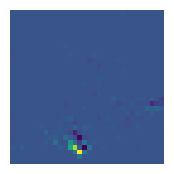

In [57]:
#TL;DR this box loads the dataset events
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
events, _ = dataset[8]
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.25),
                                      transforms.ToFrame(sensor_size=(32,32,2),
                                                         time_window=10_000) ])

trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

batch_size = 8

subsample_percent = 10

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset = Subset(testset,  test_subsample_idx)
##########################################

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))
frames, targets = next(iter(train_loader))

In [58]:

y.shape

frames = frame_transform(events)
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())

torch.Size([8, 199, 2, 64, 64])

In [128]:
frames[:,0,0].shape

torch.Size([199, 64, 64])

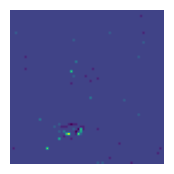

In [129]:
ani = tonic.utils.plot_animation(frames[:,0])
HTML(ani.to_jshtml())